In [1]:
from pprint import pprint 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import praw
user_agent="Scraper 1.0 by /u/kav_yay"
reddit=praw.Reddit(
client_id="YCp6d62ye13q-A",
client_secret="ytcu1vnZJyHO_pK2PZC_fX2Q6ImfSA",
user_agent=user_agent
)

In [3]:
title_list = []
num_comments_list = []
link_flair_text_list = []
body_list = []

In [4]:
flairs=["TW Multiple Trigger Warning","TW Physical Violence","Preparing To Leave","TW: Threats of Violence"]

In [5]:
subreddit = reddit.subreddit('domesticviolence')
hot_post = subreddit.hot(limit=None)
for sub in hot_post:
    if sub.link_flair_text=="TW Multiple Trigger Warning" or sub.link_flair_text=="TW Physical Violence" or sub.link_flair_text=="Preparing To Leave" or sub.link_flair_text=="TW: Threats of Violence":
        title_list.append(sub.title)
        link_flair_text_list.append(sub.link_flair_text)
        num_comments_list.append(sub.num_comments)
        body_list.append(sub.selftext)

In [6]:
df = pd.DataFrame({ 'Title':title_list,
                   'Count_of_Comments':num_comments_list,
                   'Body':body_list,
                   'Flair':link_flair_text_list
                  })
df.to_csv('DV_praw.csv', index = False)


In [7]:
len(df)

450

In [8]:
#Basic Libraries
import re
import sys
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from topic_model_function import *

C:\Users\saika\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [9]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from','subject','re','edu','use','domestic','abuse','violence','relationship','physical','dv','leave'])

In [10]:
#Load Dataset
df=pd.read_csv('DV_praw.csv')
#getting rid of NaN
df=df.replace(np.nan, '', regex=True)
#getting rid of deleted values
df['Body']=df['Body'].replace('[deleted]','')
#Combining title and text
df["Post"] = df["Title"] + df["Body"]
#Now that we don't need Title or Text, we drop those columns before saving the file
df=df.drop(['Title', 'Body'], axis = 1)

In [11]:
df=df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [12]:
df.head()

,Count_of_Comments,Flair,Post
0,6,TW Multiple Trigger Warning,Why do I feel so bad that my abuser is probabl...
1,1,TW Multiple Trigger Warning,It’s been a year.We had that once in a lifetim...
2,3,TW Multiple Trigger Warning,GratefulHello!\nI’m a little (very) tipsy righ...
3,8,TW Physical Violence,There’s nothing left you can do to meAfter\n- ...
4,5,TW Physical Violence,How did you officially cut ties with your abus...


In [13]:
# Convert to list
data=df.Post.values.tolist()
# Remove new line characters
data=[re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data=[re.sub("\'", "", sent) for sent in data]

In [14]:
#Function to clean up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

In [15]:
#Clean up text
data_words=list(sent_to_words(data))
print(data_words[:1])

[['why', 'do', 'feel', 'so', 'bad', 'that', 'my', 'abuser', 'is', 'probably', 'going', 'to', 'jail', 'left', 'my', 'ex', 'husband', 'years', 'ago', 'after', 'he', 'strangled', 'me', 'we', 'have', 'child', 'together', 'who', 'was', 'months', 'old', 'at', 'the', 'time', 'called', 'the', 'cops', 'and', 'left', 'and', 'got', 'an', 'order', 'of', 'protection', 'he', 'was', 'given', 'supervised', 'visitation', 'for', 'years', 'he', 'was', 'also', 'charged', 'by', 'the', 'states', 'attorneys', 'office', 'since', 'didnt', 'press', 'charges', 'they', 'charged', 'him', 'with', 'felony', 'for', 'aggravated', 'domestic', 'battery', 'strangulation', 'felony', 'for', 'unlawful', 'restraint', 'and', 'misdemeanors', 'for', 'domestic', 'battery', 'they', 'dropped', 'the', 'aggravated', 'domestic', 'battery', 'strangulation', 'charge', 'and', 'he', 'accepted', 'plea', 'deal', 'for', 'the', 'unlawful', 'restraint', 'charge', 'they', 'gave', 'him', 'years', 'of', 'probation', 'and', 'required', 'him', 'to

In [16]:
# Build the bigram and trigram models
bigram=gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram=gensim.models.Phrases(bigram[data_words], threshold=100)

In [17]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod=gensim.models.phrases.Phraser(bigram)
trigram_mod=gensim.models.phrases.Phraser(trigram)

In [18]:
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['why', 'do', 'feel', 'so', 'bad', 'that', 'my', 'abuser', 'is', 'probably', 'going', 'to', 'jail', 'left', 'my', 'ex', 'husband', 'years', 'ago', 'after', 'he', 'strangled', 'me', 'we', 'have', 'child', 'together', 'who', 'was', 'months', 'old', 'at', 'the', 'time', 'called', 'the', 'cops', 'and', 'left', 'and', 'got', 'an', 'order', 'of', 'protection', 'he', 'was', 'given', 'supervised', 'visitation', 'for', 'years', 'he', 'was', 'also', 'charged', 'by', 'the', 'states', 'attorneys', 'office', 'since', 'didnt', 'press_charges', 'they', 'charged', 'him', 'with', 'felony', 'for', 'aggravated', 'domestic', 'battery', 'strangulation', 'felony', 'for', 'unlawful', 'restraint', 'and', 'misdemeanors', 'for', 'domestic', 'battery', 'they', 'dropped', 'the', 'aggravated', 'domestic', 'battery', 'strangulation', 'charge', 'and', 'he', 'accepted', 'plea', 'deal', 'for', 'the', 'unlawful', 'restraint', 'charge', 'they', 'gave', 'him', 'years', 'of', 'probation', 'and', 'required', 'him', 'to', '

In [19]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [20]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [21]:
#----- CHANGED ------#

data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm')

# 1. Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

# 2. Create Dictionary needed for topic modelling
id2word = corpora.Dictionary(data_lemmatized)

# 3. Create Corpus
texts = data_lemmatized

# 4. Term Document Frequency and Create a bag of words
bow_corpus = bow(dictionary=id2word, processed_docs=texts)

# 5. Calculate low_tfidf_words
# Keep only words with tfidf ranking <= x * len(dictionary)
x = 0.2
total_word_count, DictDocFreq = tf_df(bow_corpus, id2word)
sorted_TFIDF = sort_tfidf(bow_corpus, total_word_count, DictDocFreq)
low_tfidf_words = get_low_tfidf_words(x, id2word, sorted_TFIDF)

# 6. Filter out least frequently used words
no_below = 0.01
keep_n = 10000
dict_least_freq_filtered = filter_least_frequent(id2word, texts, 
                                                 no_below, keep_n)

# 7. Filter out most commonly used words (i.e. words with low TF-IDF score)
dict_tfidf_filtered = filter_most_common(dict_least_freq_filtered, low_tfidf_words)

# 8. Create the second bag of words - bow_corpus_TFIDFfiltered, 
# created after least frequently and most commonly used words were filtered out.
corpus = bow(dict_tfidf_filtered, texts)

# View
[[(dict_tfidf_filtered[id], freq) for id, freq in cp] for cp in corpus[:1]]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dict_tfidf_filtered,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=1000,
                                           passes=50,
                                           alpha='auto',
                                           iterations=100,
                                           per_word_topics=True)

[['feel', 'bad', 'abuser', 'probably', 'go', 'jail', 'leave', 'ex', 'husband', 'year', 'ago', 'strangle', 'child', 'together', 'month', 'old', 'time', 'call', 'cop', 'leave', 'get', 'order', 'protection', 'give', 'supervise', 'visitation', 'year', 'also', 'charge', 'state', 'attorney', 'office', 'press_charge', 'charge', 'felony', 'aggravate', 'battery', 'strangulation', 'felony', 'unlawful', 'restraint', 'misdemeanor', 'battery', 'drop', 'aggravate', 'battery', 'strangulation', 'charge', 'accept', 'plea', 'deal', 'unlawful', 'restraint', 'charge', 'give', 'year', 'probation', 'require', 'batterer', 'intervention', 'class', 'community', 'service', 'divorce', 'full', 'custody', 'give', 'unsupervised', 'visit', 'half', 'time', 'good', 'behavior', 'couple', 'year', 'thing', 'good', 'recently', 'abuse', 'son', 'spank', 'hard', 'left', 'deep', 'bruise', 'shape', 'hand', 'butt', 'traumatize', 'scare', 'go', 'back', 'unsupervised', 'reported', 'police', 'get', 'emergency', 'op', 'son', 'cps',

In [22]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.017*"mother" + 0.012*"live" + 0.011*"see" + 0.011*"also" + 0.010*"take" + '
  '0.010*"call" + 0.010*"parent" + 0.009*"kid" + 0.009*"start" + '
  '0.007*"abusive"'),
 (1,
  '0.013*"really" + 0.013*"anymore" + 0.013*"energy" + 0.013*"bond" + '
  '0.013*"bad" + 0.013*"trauma" + 0.012*"respect" + 0.011*"create" + '
  '0.011*"amount" + 0.010*"information"'),
 (2,
  '0.026*"call" + 0.020*"charge" + 0.018*"arrest" + 0.014*"police" + '
  '0.012*"even" + 0.012*"home" + 0.010*"assault" + 0.009*"mom" + '
  '0.009*"family" + 0.009*"abusive"'),
 (3,
  '0.025*"report" + 0.016*"ex" + 0.015*"bad" + 0.014*"back" + 0.012*"jail" + '
  '0.011*"give" + 0.011*"life" + 0.010*"assault" + 0.010*"police" + 0.009*"s"'),
 (4,
  '0.014*"start" + 0.011*"friend" + 0.011*"really" + 0.010*"think" + '
  '0.010*"never" + 0.009*"back" + 0.008*"day" + 0.008*"still" + 0.008*"talk" + '
  '0.008*"hit"'),
 (5,
  '0.016*"much" + 0.011*"bad" + 0.011*"move" + 0.010*"wrong" + 0.010*"stay" + '
  '0.009*"think" + 0.009*"l

In [23]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -7.076963640557645


In [24]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.2639613224099925


In [25]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [26]:

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=50, step=1)

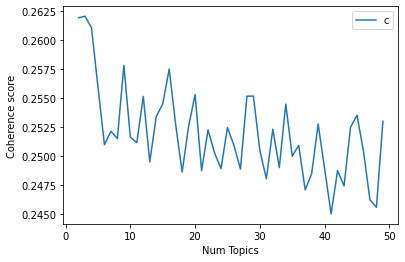

In [27]:
# Show graph
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores

In [133]:

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.262
Num Topics = 3  has Coherence Value of 0.2621
Num Topics = 4  has Coherence Value of 0.2611
Num Topics = 5  has Coherence Value of 0.256
Num Topics = 6  has Coherence Value of 0.251
Num Topics = 7  has Coherence Value of 0.2522
Num Topics = 8  has Coherence Value of 0.2515
Num Topics = 9  has Coherence Value of 0.2579
Num Topics = 10  has Coherence Value of 0.2517
Num Topics = 11  has Coherence Value of 0.2512
Num Topics = 12  has Coherence Value of 0.2552
Num Topics = 13  has Coherence Value of 0.2495
Num Topics = 14  has Coherence Value of 0.2534
Num Topics = 15  has Coherence Value of 0.2545
Num Topics = 16  has Coherence Value of 0.2575
Num Topics = 17  has Coherence Value of 0.2527
Num Topics = 18  has Coherence Value of 0.2486
Num Topics = 19  has Coherence Value of 0.2526
Num Topics = 20  has Coherence Value of 0.2553
Num Topics = 21  has Coherence Value of 0.2488
Num Topics = 22  has Coherence Value of 0.2523
Num Topics = 23  has Coh

In [143]:
# Select the model and print the topics
optimal_model = model_list[20]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(20,
  '0.012*"start" + 0.011*"take" + 0.010*"call" + 0.010*"charge" + 0.007*"work" + 0.007*"also" + 0.007*"house" + 0.006*"never" + 0.006*"live" + 0.006*"hit"'),
 (17,
  '0.009*"even" + 0.008*"mom" + 0.007*"never" + 0.007*"see" + 0.006*"take" + 0.006*"think" + 0.006*"still" + 0.006*"well" + 0.006*"call" + 0.006*"abuse"'),
 (16,
  '0.008*"take" + 0.008*"love" + 0.008*"work" + 0.008*"still" + 0.008*"start" + 0.008*"help" + 0.007*"day" + 0.007*"even" + 0.007*"call" + 0.007*"bad"'),
 (4,
  '0.011*"m" + 0.010*"friend" + 0.009*"start" + 0.008*"talk" + 0.008*"month" + 0.007*"call" + 0.007*"see" + 0.007*"need" + 0.007*"mom" + 0.006*"keep"'),
 (18,
  '0.010*"hit" + 0.008*"back" + 0.008*"come" + 0.008*"move" + 0.007*"even" + 0.007*"happen" + 0.007*"start" + 0.007*"day" + 0.007*"think" + 0.007*"ask"'),
 (11,
  '0.009*"start" + 0.008*"need" + 0.008*"take" + 0.007*"think" + 0.007*"call" + 0.007*"back" + 0.007*"friend" + 0.007*"home" + 0.006*"family" + 0.006*"mom"'),
 (7,
  '0.010*"keep" + 0.010*"

In [144]:
topic_words = []
for i in range(20):
    tt = lda_model.get_topic_terms(i,10)
    topic_words.append([id2word[pair[0]] for pair in tt])

In [145]:
for i in range(0,20):
    print(topic_words[i])

['mother', 'live', 'see', 'also', 'take', 'call', 'parent', 'kid', 'start', 'abusive']
['really', 'anymore', 'energy', 'bond', 'bad', 'trauma', 'respect', 'create', 'amount', 'information']
['call', 'charge', 'arrest', 'police', 'even', 'home', 'assault', 'mom', 'family', 'abusive']
['report', 'ex', 'bad', 'back', 'jail', 'give', 'life', 'assault', 'police', 's']
['start', 'friend', 'really', 'think', 'never', 'back', 'day', 'still', 'talk', 'hit']
['much', 'bad', 'move', 'wrong', 'stay', 'think', 'landlord', 'break', 'slap', 'ex']
['dog', 'help', 'work', 'threaten', 'kill', 'well', 'take', 'abusive', 'divorce', 'care']
['strangle', 'laugh', 'happen', 'never', 's', 'last', 'good', 'fight', 'mom', 'use']
['sister', 'm', 'still', 'car', 'call', 'work', 'scared', 'back', 'cop', 'hit']
['d', 'move', 'well', 'leave', 'back', 'start', 'dog', 'love', 'month', 'even']
['abusive', 'home', 'give', 'live', 'police', 'still', 'm', 'much', 'think', 'cause']
['m', 'month', 'talk', 'even', 'give', 'a

In [146]:
df=pd.DataFrame({'Source':[],'Topic_ID':[],'Most_freq_words':[]})
df.head()

,Source,Topic_ID,Most_freq_words


In [138]:
df['Most_freq_words']=topic_words

In [139]:
df = df.assign(Source='Reddit')

In [140]:
ls=[]
for i in range(0,20):
    ls.append(i)
df['Topic_ID']=ls

In [141]:
df.head(20)

,Source,Topic_ID,Most_freq_words
0,Reddit,0,"[mother, live, see, also, take, call, parent, kid, start, abusive]"
1,Reddit,1,"[really, anymore, energy, bond, bad, trauma, respect, create, amount, information]"
2,Reddit,2,"[call, charge, arrest, police, even, home, assault, mom, family, abusive]"
3,Reddit,3,"[report, ex, bad, back, jail, give, life, assault, police, s]"
4,Reddit,4,"[start, friend, really, think, never, back, day, still, talk, hit]"
5,Reddit,5,"[much, bad, move, wrong, stay, think, landlord, break, slap, ex]"
6,Reddit,6,"[dog, help, work, threaten, kill, well, take, abusive, divorce, care]"
7,Reddit,7,"[strangle, laugh, happen, never, s, last, good, fight, mom, use]"
8,Reddit,8,"[sister, m, still, car, call, work, scared, back, cop, hit]"
9,Reddit,9,"[d, move, well, leave, back, start, dog, love, month, even]"


In [142]:
df.to_csv("DV_Reddit.csv")

In [110]:
# Getting dominant topics from the document 
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            
#print(dominant_topics, topic_percentages)

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 10 Keywords for each Topic
topic_top10words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 10]

df_top10words_stacked = pd.DataFrame(topic_top10words, columns=['topic_id', 'words'])
df_top10words = df_top10words_stacked.groupby('topic_id').agg(', \n'.join)
df_top10words.reset_index(level=0,inplace=True)


In [111]:
pd.set_option('display.max_colwidth', -1)

<ipython-input-111-0891b765a168>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [112]:
df_top10words['corpus']="Reddit"
df_top10words

,topic_id,words,corpus
0,0,"mother, \nlive, \nsee, \nalso, \ntake, \ncall, \nparent, \nkid, \nstart, \nabusive",Reddit
1,1,"really, \nanymore, \nenergy, \nbond, \nbad, \ntrauma, \nrespect, \ncreate, \namount, \ninformation",Reddit
2,4,"start, \nfriend, \nreally, \nthink, \nnever, \nback, \nday, \nstill, \ntalk, \nhit",Reddit
3,5,"much, \nbad, \nmove, \nwrong, \nstay, \nthink, \nlandlord, \nbreak, \nslap, \nex",Reddit
4,7,"strangle, \nlaugh, \nhappen, \nnever, \ns, \nlast, \ngood, \nfight, \nmom, \nuse",Reddit
5,9,"d, \nmove, \nwell, \nleave, \nback, \nstart, \ndog, \nlove, \nmonth, \neven",Reddit
6,10,"abusive, \nhome, \ngive, \nlive, \npolice, \nstill, \nm, \nmuch, \nthink, \ncause",Reddit
7,13,"even, \nhelp, \nthink, \nm, \nabusive, \nalso, \nhusband, \nstill, \nmove, \nreally",Reddit
8,15,"take, \ncar, \nback, \nstart, \nhit, \ncome, \nhappen, \ncall, \nnever, \nday",Reddit
9,18,"mom, \nsister, \ncall, \nday, \nthink, \nfamily, \nsee, \nwork, \ntalk, \nwell",Reddit


In [113]:
df_top10words=df_top10words.drop_duplicates(subset=['words'])
df_top10words

,topic_id,words,corpus
0,0,"mother, \nlive, \nsee, \nalso, \ntake, \ncall, \nparent, \nkid, \nstart, \nabusive",Reddit
1,1,"really, \nanymore, \nenergy, \nbond, \nbad, \ntrauma, \nrespect, \ncreate, \namount, \ninformation",Reddit
2,4,"start, \nfriend, \nreally, \nthink, \nnever, \nback, \nday, \nstill, \ntalk, \nhit",Reddit
3,5,"much, \nbad, \nmove, \nwrong, \nstay, \nthink, \nlandlord, \nbreak, \nslap, \nex",Reddit
4,7,"strangle, \nlaugh, \nhappen, \nnever, \ns, \nlast, \ngood, \nfight, \nmom, \nuse",Reddit
5,9,"d, \nmove, \nwell, \nleave, \nback, \nstart, \ndog, \nlove, \nmonth, \neven",Reddit
6,10,"abusive, \nhome, \ngive, \nlive, \npolice, \nstill, \nm, \nmuch, \nthink, \ncause",Reddit
7,13,"even, \nhelp, \nthink, \nm, \nabusive, \nalso, \nhusband, \nstill, \nmove, \nreally",Reddit
8,15,"take, \ncar, \nback, \nstart, \nhit, \ncome, \nhappen, \ncall, \nnever, \nday",Reddit
9,18,"mom, \nsister, \ncall, \nday, \nthink, \nfamily, \nsee, \nwork, \ntalk, \nwell",Reddit


In [114]:
df_dt=df_top10words[0:5]
df_dt

,topic_id,words,corpus
0,0,"mother, \nlive, \nsee, \nalso, \ntake, \ncall, \nparent, \nkid, \nstart, \nabusive",Reddit
1,1,"really, \nanymore, \nenergy, \nbond, \nbad, \ntrauma, \nrespect, \ncreate, \namount, \ninformation",Reddit
2,4,"start, \nfriend, \nreally, \nthink, \nnever, \nback, \nday, \nstill, \ntalk, \nhit",Reddit
3,5,"much, \nbad, \nmove, \nwrong, \nstay, \nthink, \nlandlord, \nbreak, \nslap, \nex",Reddit
4,7,"strangle, \nlaugh, \nhappen, \nnever, \ns, \nlast, \ngood, \nfight, \nmom, \nuse",Reddit


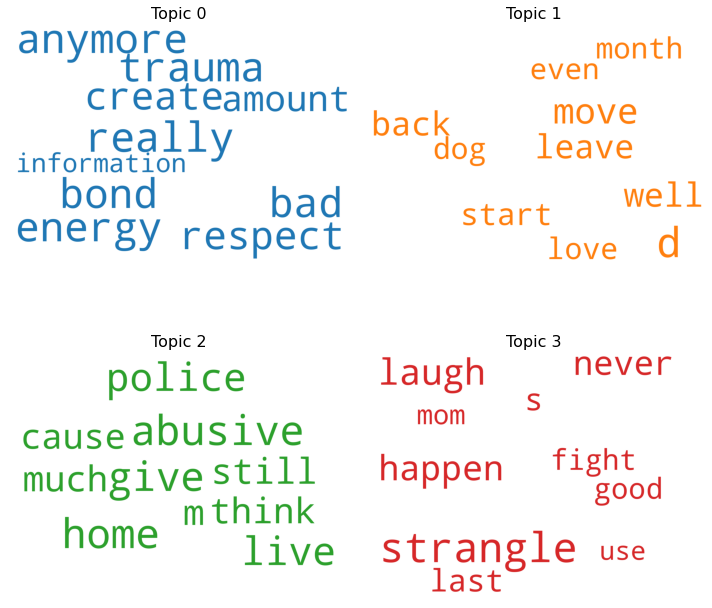

In [115]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()